# Prototypical Network

### Imports

In [1]:
import os, glob, platform, random, json, copy, math
from pathlib import Path
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

from collections import defaultdict

d:\Anaconda\envs\TFM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
# Configuración del dataset
DATA_ROOT   = "E:/TFM/Dataset_una_clase"   # {train,val,test}/{negative,positive}
IMAGE_SIZE  = 224
BATCH_SIZE  = 16         # solo para sanity checks / evaluación por lotes
SEED        = 42

# 0 para evitar errores de multiprocessing en Windows
NUM_WORKERS = 0 if platform.system().lower().startswith("win") else 4

# Entrenamiento
N_WAY   = 2        # binary
K_SHOT  = 8        # imágenes por clase en el soporte (ajusta 4..16)
Q_QUERY = 8        # queries por clase en cada episodio
EPISODES_PER_EPOCH = 100
EPOCHS  = 50
LR      = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 10
OUT_DIR = "E:/TFM/modelos/Outputs_proto"

# Variantes a comparar
MODE = "single_all"   # "single_all" | "multi_kmeans"
M_PROTOS_PER_CLASS = 3     # solo aplica a "multi_kmeans"
LEARN_TAU = True           # activa temperature scaling aprendible en VAL

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibilidad
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()



Device: cuda


### Transforms

In [3]:
def _resize(img_size: int):
    return A.Resize(height=img_size, width=img_size)

def _random_resized_crop(img_size: int):
    try:
        return A.RandomResizedCrop(size=(img_size, img_size), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)
    except TypeError:
        return A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)

train_tf = A.Compose([
    _random_resized_crop(IMAGE_SIZE),
    A.Affine(
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        scale=(0.9, 1.1), 
        rotate=(-7, 7),
        interpolation=cv2.INTER_LINEAR, 
        border_mode=cv2.BORDER_CONSTANT, 
        p=0.9
    ),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.RandomBrightnessContrast(0.10, 0.10, p=0.7),
    A.GaussianBlur(blur_limit=(3, 3), p=0.2),
    A.Normalize(mean=[0.5]*3, std=[0.25]*3),
    ToTensorV2(),
])

eval_tf = A.Compose([
    _resize(IMAGE_SIZE),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    ToTensorV2(),
])


### Dataset

In [4]:
class ChestXrayDataset(Dataset):
    def __init__(self, root_split_dir, transform=None):
        self.root = root_split_dir
        self.transform = transform
        self.class_to_idx = {"negative": 0, "positive": 1}
        self.samples = []

        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff")
        for cls in ["negative", "positive"]:
            for ext in exts:
                for f in glob.glob(os.path.join(self.root, cls, ext)):
                    self.samples.append((f, self.class_to_idx[cls]))

        # filtrar ilegibles
        valid, skipped = [], []
        for path, label in self.samples:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None or img.size == 0:
                skipped.append(path)
            else:
                valid.append((path, label))
        if skipped:
            print(f"[WARN] {len(skipped)} ilegibles en {self.root}, se omiten.")
        self.samples = shuffle(valid, random_state=SEED)
        if len(self.samples) == 0:
            raise RuntimeError(f"No hay imágenes en {self.root}")
        
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.transform: 
            img = self.transform(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.long)

def make_loaders():
    train_ds = ChestXrayDataset(os.path.join(DATA_ROOT, "train"), transform=train_tf)
    val_ds   = ChestXrayDataset(os.path.join(DATA_ROOT, "val"),   transform=eval_tf)
    test_ds  = ChestXrayDataset(os.path.join(DATA_ROOT, "test"),  transform=eval_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=False)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=False)
    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders()
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| Labels shape:", labels.shape)
print("Post-Normalize -> mean:", imgs.float().mean().item(), "std:", imgs.float().std().item())


Train: 278 | Val: 93 | Test: 93
Batch shape: torch.Size([16, 3, 224, 224]) | Labels shape: torch.Size([16])
Post-Normalize -> mean: -0.0785338506102562 std: 1.1591399908065796


### Encoder (Backbone) + Proto Head

In [5]:
class ResNetEncoder(nn.Module):
    def __init__(self, pretrained=True, out_dim=2048, proj_dim=512):
        super().__init__()
        try:
            weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
            base = models.resnet50(weights=weights)
        except Exception:
            base = models.resnet50(pretrained=pretrained)
        modules = list(base.children())[:-1]  # quitar FC
        self.backbone = nn.Sequential(*modules)  # -> [B, 2048, 1, 1]
        self.out_dim = out_dim
        self.proj = nn.Sequential(
            nn.Flatten(),
            nn.Linear(out_dim, proj_dim),
            nn.ReLU(inplace=True)
        )
        self.l2norm = nn.functional.normalize
    def forward(self, x):
        feats = self.backbone(x)           # [B,2048,1,1]
        emb = self.proj(feats)             # [B,proj_dim]
        emb = self.l2norm(emb, dim=1)
        return emb

def pairwise_euclidean(a, b):
    # a: [M,D], b:[N,D] -> [M,N]
    a2 = (a*a).sum(dim=1, keepdim=True)   # [M,1]
    b2 = (b*b).sum(dim=1, keepdim=True).T # [1,N]
    ab = a @ b.T
    return a2 + b2 - 2*ab

### Entrenamiento

In [6]:
def index_by_class(ds):
    idxs = defaultdict(list)
    for i, (_, y) in enumerate(ds.samples):
        idxs[y].append(i)
    return idxs

train_index = index_by_class(train_ds)
val_index   = index_by_class(val_ds)
test_index  = index_by_class(test_ds)

def sample_episode(ds, idx_by_class, n_way=2, k_shot=5, q_query=5):
    classes = [0,1] if n_way==2 else sorted(idx_by_class.keys())[:n_way]
    xs_list, ys_list, xq_list, yq_list = [], [], [], []
    for c in classes:
        idxs = np.random.choice(idx_by_class[c], size=k_shot+q_query, replace=len(idx_by_class[c])<(k_shot+q_query))
        s_idx = idxs[:k_shot]; q_idx = idxs[k_shot:]
        for ii in s_idx:
            x,_ = ds[ii]; xs_list.append(x); ys_list.append(c)
        for ii in q_idx:
            x,_ = ds[ii]; xq_list.append(x); yq_list.append(c)
    xs = torch.stack(xs_list, dim=0); ys = torch.tensor(ys_list, dtype=torch.long)
    xq = torch.stack(xq_list, dim=0); yq = torch.tensor(yq_list, dtype=torch.long)
    return xs, ys, xq, yq

def episodic_loss(encoder, xs, ys, xq, yq, device):
    xs = xs.to(device); xq = xq.to(device)
    ys = ys.to(device); yq = yq.to(device)
    emb_s = encoder(xs)   # [N_way*K, D]
    emb_q = encoder(xq)   # [N_way*Q, D]
    classes = torch.unique(ys)
    protos = []
    for c in classes:
        protos.append(emb_s[ys==c].mean(dim=0))
    protos = torch.stack(protos, dim=0)             # [N_way, D]
    protos = nn.functional.normalize(protos, dim=1)
    logits = emb_q @ protos.T                       # similitud coseno
    label_map = {int(c.item()):i for i,c in enumerate(classes)}
    yq_mapped = torch.tensor([label_map[int(t.item())] for t in yq], device=device)
    loss = nn.CrossEntropyLoss()(logits, yq_mapped)
    acc = (logits.argmax(dim=1)==yq_mapped).float().mean().item()
    return loss, acc


def train_encoder(train_ds, val_ds):
    os.makedirs(OUT_DIR, exist_ok=True)
    encoder = ResNetEncoder(pretrained=True).to(device)
    opt = optim.AdamW(encoder.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sch = CosineAnnealingLR(opt, T_max=EPOCHS)
    best_state, best_auc, no_imp = None, -1, 0
    tr_idx = index_by_class(train_ds)

    for ep in range(EPOCHS):
        encoder.train()
        losses, accs = [], []
        for _ in tqdm(range(EPISODES_PER_EPOCH), leave=False, desc=f"Epoch {ep+1}/{EPOCHS}"):
            xs, ys, xq, yq = sample_episode(train_ds, tr_idx, N_WAY, K_SHOT, Q_QUERY)
            # >>> aquí pasamos device <<<
            loss, acc = episodic_loss(encoder, xs, ys, xq, yq, device)
            opt.zero_grad(set_to_none=True)
            loss.backward(); opt.step()
            losses.append(loss.item()); accs.append(acc)
        sch.step()

        # Early stopping: AUC@tau=1 con protos rápidos de TRAIN (K_SHOT)
        encoder.eval()
        with torch.no_grad():
            # construir protos rápidos (K_SHOT por clase)
            sup_imgs, sup_lbls = [], []
            for c in [0,1]:
                perm = np.random.permutation(tr_idx[c])[:min(K_SHOT, len(tr_idx[c]))]
                for ii in perm:
                    x,_ = train_ds[ii]; sup_imgs.append(x); sup_lbls.append(c)
            sup = torch.stack(sup_imgs).to(device)
            emb = encoder(sup); emb = nn.functional.normalize(emb, dim=1)
            prot_neg = emb[torch.tensor(sup_lbls)==0].mean(dim=0, keepdim=True)
            prot_pos = emb[torch.tensor(sup_lbls)==1].mean(dim=0, keepdim=True)
            protos = torch.cat([prot_neg, prot_pos], dim=0)
            protos = nn.functional.normalize(protos, dim=1)

            # probs en VAL
            loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
            probs, ys = [], []
            for x,y in loader:
                x = x.to(device)
                e = encoder(x); e = nn.functional.normalize(e, dim=1)
                logits = e @ protos.T
                p = torch.softmax(logits, dim=1)[:,1]
                probs.append(p.cpu().numpy()); ys.append(y.numpy())
            pv = np.concatenate(probs,0); yv = np.concatenate(ys,0)
            try:
                auc = roc_auc_score(yv, pv)
                ap  = average_precision_score(yv, pv)
            except Exception:
                auc, ap = 0.0, 0.0

        print(f"[E{ep+1}] loss={np.mean(losses):.4f} | episodic_acc={np.mean(accs):.3f} | val_auc≈{auc:.3f} | val_pr≈{ap:.3f}")
        if auc > best_auc:
            best_auc = auc; no_imp = 0
            best_state = copy.deepcopy(encoder.state_dict())
            torch.save(best_state, os.path.join(OUT_DIR, "best_proto.pt"))
        else:
            no_imp += 1
            if no_imp >= PATIENCE:
                print("Early stopping.")
                break

    if best_state is not None:
        encoder.load_state_dict(best_state)
    return encoder

encoder = train_encoder(train_ds, val_ds)

[E1] loss=0.5611 | episodic_acc=0.774 | val_auc≈0.880 | val_pr≈0.894


[E2] loss=0.4029 | episodic_acc=0.926 | val_auc≈0.894 | val_pr≈0.905


[E3] loss=0.3515 | episodic_acc=0.971 | val_auc≈0.851 | val_pr≈0.872


[E4] loss=0.3403 | episodic_acc=0.979 | val_auc≈0.850 | val_pr≈0.879


[E5] loss=0.3294 | episodic_acc=0.990 | val_auc≈0.851 | val_pr≈0.876


[E6] loss=0.3306 | episodic_acc=0.989 | val_auc≈0.877 | val_pr≈0.898


[E7] loss=0.3269 | episodic_acc=0.989 | val_auc≈0.884 | val_pr≈0.903


[E8] loss=0.3332 | episodic_acc=0.984 | val_auc≈0.850 | val_pr≈0.868


[E9] loss=0.3187 | episodic_acc=0.996 | val_auc≈0.836 | val_pr≈0.850


[E10] loss=0.3191 | episodic_acc=0.997 | val_auc≈0.846 | val_pr≈0.861


[E11] loss=0.3144 | episodic_acc=1.000 | val_auc≈0.846 | val_pr≈0.843


[E12] loss=0.3202 | episodic_acc=0.995 | val_auc≈0.860 | val_pr≈0.875
Early stopping.


### Evaluación

In [7]:
def embeddings_of_dataset(ds, encoder, batch_size=64):
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    embs, ys = [], []
    for x,y in loader:
        x = x.to(device)
        e = encoder(x)
        e = nn.functional.normalize(e, dim=1)
        embs.append(e.cpu()); ys.append(y)
    return torch.cat(embs,0), torch.cat(ys,0)

def build_prototypes_from_all(train_ds, encoder):
    E, Y = embeddings_of_dataset(train_ds, encoder)
    Y = Y.numpy()
    prot_neg = E[torch.tensor(Y)==0].mean(dim=0, keepdim=True)
    prot_pos = E[torch.tensor(Y)==1].mean(dim=0, keepdim=True)
    protos = torch.cat([prot_neg, prot_pos], dim=0)
    protos = nn.functional.normalize(protos, dim=1)
    return protos

def build_multi_prototypes(train_ds, encoder, m_per_class=3):
    E, Y = embeddings_of_dataset(train_ds, encoder)
    E_np, Y_np = E.numpy(), Y.numpy()
    protos = []
    for c in [0,1]:
        Ec = E_np[Y_np==c]
        k = min(m_per_class, max(1, len(Ec)))
        if k == 1:
            proto_c = Ec.mean(axis=0, keepdims=True)
        else:
            km = KMeans(n_clusters=k, n_init=10, random_state=SEED).fit(Ec)
            proto_c = km.cluster_centers_
        protos.append(torch.tensor(proto_c, dtype=torch.float32))
    protos = torch.vstack(protos)
    protos = nn.functional.normalize(protos, dim=1)
    return protos

@torch.no_grad()
def probs_from_single_protos(encoder, ds, protos, tau=1.0, batch_size=64):
    protos_dev = protos.to(device)                          # <-- mover a device
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    probs, ys = [], []
    for x,y in loader:
        x = x.to(device)
        e = encoder(x); e = nn.functional.normalize(e, dim=1)
        logits = (e @ protos_dev.T) / tau                   # [B,2]
        p = torch.softmax(logits, dim=1)[:,1]
        probs.append(p.cpu().numpy()); ys.append(y.numpy())
    return np.concatenate(probs,0), np.concatenate(ys,0)

@torch.no_grad()
def probs_from_multi_protos(encoder, ds, protos, m_per_class=3, tau=1.0, batch_size=64):
    protos_dev = protos.to(device)                          # <-- mover a device
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    probs, ys = [], []
    for x,y in loader:
        x = x.to(device)
        e = encoder(x); e = nn.functional.normalize(e, dim=1)  # [B,D]
        sims = e @ protos_dev.T                                # [B, M0+M1]
        s_neg = sims[:, :m_per_class].max(dim=1, keepdim=True).values
        s_pos = sims[:, m_per_class:].max(dim=1, keepdim=True).values
        logits = torch.cat([s_neg, s_pos], dim=1) / tau
        p = torch.softmax(logits, dim=1)[:,1]
        probs.append(p.cpu().numpy()); ys.append(y.numpy())
    return np.concatenate(probs,0), np.concatenate(ys,0)

In [8]:
class TemperatureScaler(nn.Module):
    def __init__(self, init_tau=1.0):
        super().__init__()
        self.log_tau = nn.Parameter(torch.tensor([math.log(init_tau)], dtype=torch.float32))
    def forward(self, logits):
        return logits / torch.exp(self.log_tau)

def collect_logits_and_targets(encoder, ds, protos, multi=False, m_per_class=3, batch_size=64):
    protos_dev = protos.to(device)                          # <-- mover a device
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS, pin_memory=False)
    logits_list, targets_list = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device)
            e = encoder(x); e = nn.functional.normalize(e, dim=1)
            if multi:
                sims = e @ protos_dev.T
                s_neg = sims[:, :m_per_class].max(dim=1, keepdim=True).values
                s_pos = sims[:, m_per_class:].max(dim=1, keepdim=True).values
                logits = torch.cat([s_neg, s_pos], dim=1)      # [B,2]
            else:
                logits = e @ protos_dev.T                      # [B,2]
            logits_list.append(logits)
            targets_list.append(y.to(device, dtype=torch.long))
    return torch.cat(logits_list,0), torch.cat(targets_list,0)

def fit_temperature_on_val(encoder, val_ds, protos, multi=False, m_per_class=3, max_iter=200, lr=0.05):
    logits, y = collect_logits_and_targets(encoder, val_ds, protos, multi=multi, m_per_class=m_per_class)
    scaler = TemperatureScaler(init_tau=1.0).to(device)
    ce = nn.CrossEntropyLoss()
    opt = torch.optim.LBFGS(scaler.parameters(), lr=lr, max_iter=max_iter)

    def closure():
        opt.zero_grad()
        loss = ce(scaler(logits), y) 
        loss.backward()
        return loss

    opt.step(closure)
    with torch.no_grad():
        tau = float(torch.exp(scaler.log_tau).item())
    return tau

In [9]:
def find_threshold_for_spec(probs, targets, target_spec=0.95):
    ts = np.linspace(0,1,1001); best = {"thr": 0.5, "sens": 0.0, "spec": 0.0}
    for t in ts:
        preds = (probs >= t).astype(np.int64)
        tn = np.sum((preds==0) & (targets==0)); fp = np.sum((preds==1) & (targets==0))
        tp = np.sum((preds==1) & (targets==1)); fn = np.sum((preds==0) & (targets==1))
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0; sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        if spec >= target_spec and sens > best["sens"]:
            best = {"thr": float(t), "sens": float(sens), "spec": float(spec)}
    return best

def find_threshold_max_f1(probs, targets):
    ts = np.linspace(0,1,1001); best = {"thr": 0.5, "f1": 0.0}
    for t in ts:
        preds = (probs >= t).astype(np.int64)
        tp = np.sum((preds==1) & (targets==1)); fp = np.sum((preds==1) & (targets==0)); fn = np.sum((preds==0) & (targets==1))
        f1 = (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
        if f1 > best["f1"]:
            best = {"thr": float(t), "f1": float(f1)}
    return best

def eval_with_thr(probs, targets, thr):
    preds = (probs >= thr).astype(np.int64)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
    acc  = (tp+tn)/(tp+tn+fp+fn)
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
    return {"acc":acc, "sens":sens, "spec":spec, "f1":f1, "tp":tp, "fp":fp, "tn":tn, "fn":fn}


In [10]:
if MODE == "single_all":
    protos_train = build_prototypes_from_all(train_ds, encoder)
    multi = False
elif MODE == "multi_kmeans":
    protos_train = build_multi_prototypes(train_ds, encoder, m_per_class=M_PROTOS_PER_CLASS)
    multi = True
else:
    raise ValueError("MODE debe ser 'single_all' o 'multi_kmeans'")

In [11]:
if LEARN_TAU:
    tau_val = fit_temperature_on_val(
        encoder, val_ds, protos_train,
        multi=(MODE=="multi_kmeans"), m_per_class=M_PROTOS_PER_CLASS
)
    print(f"[Temperature scaling] τ aprendido en VAL: {tau_val:.3f}")
else:
    # barrido de taus (si prefieres no aprender τ)
    taus = np.geomspace(0.25, 4.0, 13)
    scores = []
    for tau in taus:
        if multi:
            pv, yv = probs_from_multi_protos(encoder, val_ds, protos_train, M_PROTOS_PER_CLASS, tau, BATCH_SIZE)
        else:
            pv, yv = probs_from_single_protos(encoder, val_ds, protos_train, tau, BATCH_SIZE)
        try:
            scores.append((tau, roc_auc_score(yv, pv)))
        except Exception:
            scores.append((tau, 0.0))
    tau_val = max(scores, key=lambda x: x[1])[0]
    print(f"[Grid τ] Mejor τ en VAL por AUC: {tau_val:.3f}")

[Temperature scaling] τ aprendido en VAL: 0.892


In [12]:
if multi:
    pv, yv = probs_from_multi_protos(encoder, val_ds, protos_train, M_PROTOS_PER_CLASS, tau_val, BATCH_SIZE)
else:
    pv, yv = probs_from_single_protos(encoder, val_ds, protos_train, tau_val, BATCH_SIZE)

best_f1   = find_threshold_max_f1(pv, yv)
best_spec = find_threshold_for_spec(pv, yv, 0.95)
print("VAL (umbral máx-F1):", best_f1)
print("VAL (~95% spec):    ", best_spec)

VAL (umbral máx-F1): {'thr': 0.266, 'f1': 0.8351648351648352}
VAL (~95% spec):     {'thr': 0.28500000000000003, 'sens': 0.5531914893617021, 'spec': 0.9565217391304348}


In [14]:
if multi:
    ptest, ytest = probs_from_multi_protos(encoder, test_ds, protos_train, M_PROTOS_PER_CLASS, tau_val, BATCH_SIZE)
else:
    ptest, ytest = probs_from_single_protos(encoder, test_ds, protos_train, tau_val, BATCH_SIZE)

auc = roc_auc_score(ytest, ptest)
ap  = average_precision_score(ytest, ptest)

print("\n=== TEST (Proto, MODE=", MODE, ", τ=", f"{tau_val:.3f}", ") ===", sep="")
print(f"AUC: {auc:.3f} | PR-AUC: {ap:.3f}")
print("TEST @ thr(max F1 VAL):   ", eval_with_thr(ptest, ytest, best_f1["thr"]))
print("TEST @ thr(95% spec VAL): ", eval_with_thr(ptest, ytest, best_spec["thr"]))


=== TEST (Proto, MODE=single_all, τ=0.892) ===
AUC: 0.889 | PR-AUC: 0.901
TEST @ thr(max F1 VAL):    {'acc': np.float64(0.8064516129032258), 'sens': np.float64(0.782608695652174), 'spec': np.float64(0.8297872340425532), 'f1': np.float64(0.8), 'tp': np.int64(36), 'fp': np.int64(8), 'tn': np.int64(39), 'fn': np.int64(10)}
TEST @ thr(95% spec VAL):  {'acc': np.float64(0.7741935483870968), 'sens': np.float64(0.6956521739130435), 'spec': np.float64(0.851063829787234), 'f1': np.float64(0.7529411764705882), 'tp': np.int64(32), 'fp': np.int64(7), 'tn': np.int64(40), 'fn': np.int64(14)}


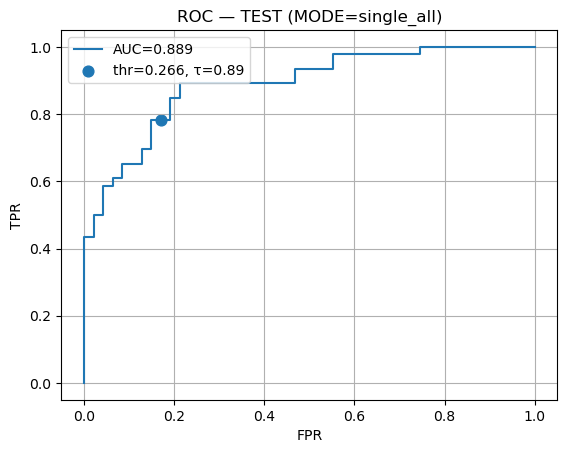

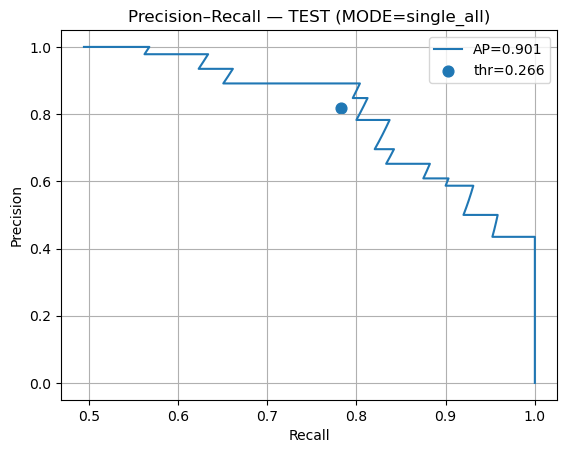

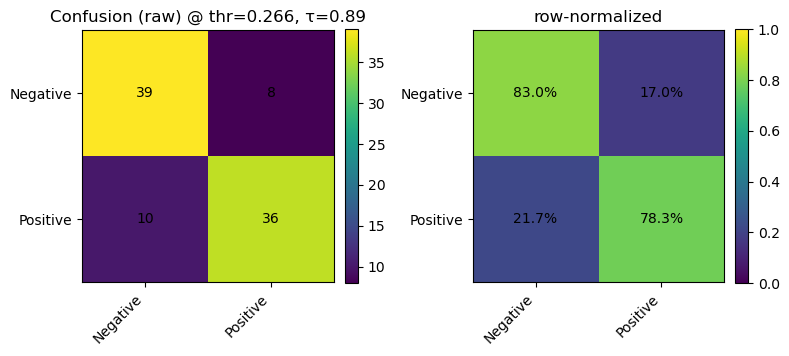

In [15]:
def plot_all(tag, probs, targets, thr, tau_used):
    auc = roc_auc_score(targets, probs)
    ap  = average_precision_score(targets, probs)
    preds = (probs>=thr).astype(np.int64)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
    tpr_point = tp/(tp+fn) if (tp+fn)>0 else 0.0
    fpr_point = fp/(fp+tn) if (fp+tn)>0 else 0.0
    prec_point = tp/(tp+fp) if (tp+fp)>0 else 0.0

    fpr, tpr, _ = roc_curve(targets, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.scatter([fpr_point],[tpr_point], s=60, label=f"thr={thr:.3f}, τ={tau_used:.2f}")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {tag}"); plt.grid(True); plt.legend(); plt.show()

    rec, prec, _ = precision_recall_curve(targets, probs)
    plt.figure(); plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.scatter([tpr_point],[prec_point], s=60, label=f"thr={thr:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"Precision–Recall — {tag}"); plt.grid(True); plt.legend(); plt.show()

    cm = confusion_matrix(targets, preds, labels=[0,1])
    cm_norm = cm.astype(float)/cm.sum(axis=1, keepdims=True).clip(min=1)

    fig, axes = plt.subplots(1,2, figsize=(8,3.8))
    ax=axes[0]; im=ax.imshow(cm); ax.set_title(f"Confusion (raw) @ thr={thr:.3f}, τ={tau_used:.2f}")
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): ax.text(j,i,int(cm[i,j]),ha="center",va="center")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax=axes[1]; im2=ax.imshow(cm_norm, vmin=0, vmax=1); ax.set_title("row-normalized")
    ax.set_xticks([0,1]); ax.set_yticks([0,1]); ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]): ax.text(j,i,f"{cm_norm[i,j]*100:.1f}%",ha="center",va="center")
    plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

plot_all(f"TEST (MODE={MODE})", ptest, ytest, best_f1["thr"], tau_val)